In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from random import sample
from tabnanny import verbose
import pandas as pd # Used for reading the csv data
from nltk.corpus import stopwords
import string # For punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import pad_sequences
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv("/content/drive/MyDrive/MLProject/spam.csv", encoding = 'latin-1')

# Remove extra columns in the data file.
df = df.iloc[:, :2]

df.columns = ['target', 'message'] # Change column names


# Sets ham to 0, spam to 1
encoder=LabelEncoder()
df['target']=encoder.fit_transform(df['target'])


stopwords = stopwords.words("english")

def data_preparation(message):
    punctuations = string.punctuation

    words = []
    for word in message.split():
        word = word.lower()
        if word not in stopwords:
            chars = []
            for char in word:
                if char not in punctuations:
                    chars.append(char)
                else:
                    chars.append(" ")
            
            new_word = "".join(chars)
            words.append(new_word) 
    
    new_message = " ".join(words)
    
    return new_message
    

# Add cleaned_messages to df
df['cleaned_message'] = df.message.apply(data_preparation)


In [4]:
targets = df.target
messages = df.cleaned_message
# print(df.cleaned_message[1084])

# Split train and test data
# - train_test_split -
#   - Split arrays or matrices into random train and test subsets
#   - test_size: should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#   - random_state: Controls the shuffling applied to the data before applying the split.
#   - stratify: mmm

messages_train, messages_test, targets_train, targets_test = train_test_split(messages, targets, test_size=0.2, random_state=20)

# mx = len(max(messages, key=len))

# Tokenize and padding

num_words = 50000 # The maximum number of words to keep, based on word frequency. 
max_len = 91

tokenizer = Tokenizer(num_words = num_words) 
tokenizer.fit_on_texts(messages_train) # Updates internal vocabulary based on a list of texts.

# Tokenize and paddin for train dataset

messages_train_features = tokenizer.texts_to_sequences(messages_train) # Updates internal vocabulary based on a list of sequences.
# print(len(max(messages_train_features, key=len))) 79
messages_train_features = pad_sequences(messages_train_features, maxlen = max_len)

# Tokenize and paddin for test dataset

messages_test_features = tokenizer.texts_to_sequences(messages_test)
# print(len(max(messages_test_features, key=len))) #91
messages_test_features = pad_sequences(messages_test_features, maxlen = max_len)

print(len(messages_train_features), len(messages_train_features[0]))
print(len(messages_test_features), len(messages_test_features[0]))


# Define the Model
model = Sequential()

# Embedding layer
model.add(Embedding(num_words, 32, input_length=max_len))

# LSTM layer
model.add(LSTM(64))

# Dense layer
model.add(Dense(16 ,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

print(model.summary())

# messages_train_features.shape,targets_train.shape # shape of train dataset
# messages_test_features.shape,targets_test.shape # shape of test dataset


4457 91
1115 91
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 91, 32)            1600000   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,625,889
Trainable params: 1,625,889
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
30/30 [==============================] - 8s 28ms/step - loss: 0.4553 - accuracy: 0.8620 - val_loss: 0.2691 - val_accuracy: 0.8673
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1852 - accuracy: 0.9345 - val_loss: 0.1191 - val_accuracy: 0.9767
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0824 - accuracy: 0.9872 - val_loss: 0.0509 - val_accuracy: 0.9874
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0230 - accuracy: 0.9948 - val_loss: 0.0383 - val_accuracy: 0.9892
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0120 - accuracy: 0.9975 - val_loss: 0.0475 - val_accuracy: 0.9901
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0081 - accuracy: 0.9982 - val_loss: 0.0407 - val_accuracy: 0.9910
Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0421 - val_accuracy: 0.9901
Epoch 8/20
30

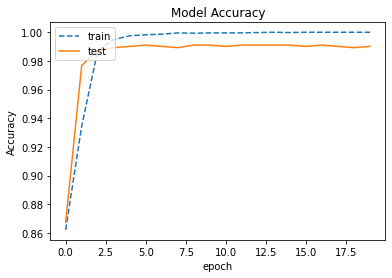

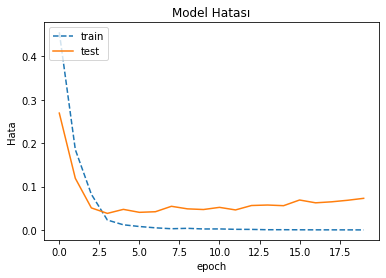

35/35 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9901
Accuracy: 99.013
35/35 [==============================] - 0s 3ms/step
[[965   2]
 [  9 139]]


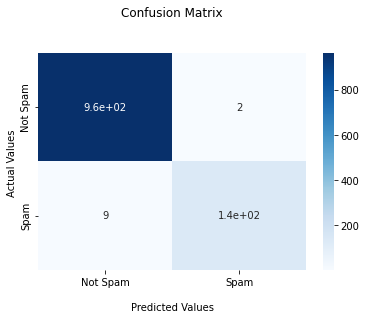

In [5]:
history=model.fit(messages_train_features,targets_train,batch_size=150,epochs=20, validation_data=(messages_test_features, targets_test))

# Model Performansı

plt.plot(history.history["accuracy"], "--")
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# # Model Hatası

plt.plot(history.history["loss"], "--")
plt.plot(history.history["val_loss"])
plt.title("Model Hatası")
plt.ylabel("Hata")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

accuracy = model.evaluate(messages_test_features,targets_test)
print('Accuracy: {:0.3f}'.format(accuracy[1]*100))

y_predict  = [1 if o>0.5 else 0 for o in model.predict(messages_test_features)]
cf_matrix =confusion_matrix(targets_test,y_predict)
print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Not Spam','Spam'])
ax.yaxis.set_ticklabels(['Not Spam','Spam'])

plt.show()

In [7]:
#Some texts to try 
#Free entry in 2 a weekly competition to win FA Cup final tkts 21st May 2005
#I'm not coming home today
#Your package is pending
#ok. i'm good
#congratulations you won! sms YES on 54233 to win
#Your 2004 account for 07XXXXXXXXX shows 786
#Hey, call ur mom she is worried
#YOU ARE CHOSEN TO RECEIVE A å£350 AWARD! Pls call claim to collect your award which you are selected to receive as a valued mobile customer

input_message = input("Please enter a message: ")

# Pre-process the input message using the same pre-processing steps used for the training data
cleaned_message = data_preparation(input_message)

# Convert the input message to a sequence of tokens
input_features = tokenizer.texts_to_sequences([cleaned_message])

# Pad the input sequence to the same length as the training data
input_features = pad_sequences(input_features, maxlen=max_len)

# Use the trained model to predict whether the input message is spam or not
prediction = model.predict(input_features)

# Print the prediction
if prediction[0] > 0.5:
    print("The input message is predicted to be SPAM.")
else:
    print("The input message is predicted to NOT be SPAM.")

Please enter a message: I'm not coming home today
1/1 [==============================] - 0s 18ms/step
The input message is predicted to NOT be SPAM.
